# **DE Yield Data Preparation**

## **Import Dependencies**

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from tqdm.auto import tqdm
from difflib import SequenceMatcher
import os
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

## **Read the Datasets**

In [127]:
# Read the shapefile for DE NUTS3
de_nuts_gdf = gpd.read_file(r"D:\GITHUB\crop-yield-prediction-germany\datasets\shapefiles\DE_NUTS\DE_NUTS_3.shp")
print(de_nuts_gdf.shape)
de_nuts_gdf.head()

(455, 9)


,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry
0,DE11B,3,DE,Main-Tauber-Kreis,Main-Tauber-Kreis,None,None,None,"POLYGON ((1074230.536 6408356.046, 1073820.827..."
1,DE11C,3,DE,Heidenheim,Heidenheim,None,None,None,"MULTIPOLYGON (((1131091.261 6235073.568, 11312..."
2,DE11D,3,DE,Ostalbkreis,Ostalbkreis,None,None,None,"MULTIPOLYGON (((1141777.678 6284962.486, 11412..."
3,DE121,3,DE,"Baden-Baden, Stadtkreis","Baden-Baden, Stadtkreis",None,None,None,"MULTIPOLYGON (((910859.613 6248068.047, 913127..."
4,DE122,3,DE,"Karlsruhe, Stadtkreis","Karlsruhe, Stadtkreis",None,None,None,"POLYGON ((938225.711 6286986.826, 940668.057 6..."


In [128]:
# Read the latest yield data for Germany for the year 2022, and 2023
de_yield_2023 = pd.read_excel(
       r"D:\GITHUB\crop-yield-prediction-germany\datasets\csvs\DE_Yield_Latest.xlsx", 
       skiprows=[i for i in range(7)], nrows=537,
       header=None,
       names=["district_no", "district", "ww", "rye",
              "wb", "sb", "oats", "triticale",
              "pota_tot", "sugarbeet", "wrape", "silage_maize"])

de_yield_2023.replace(["-", "", "/", ".", "..."], np.nan, inplace=True) # replace the special characters
de_yield_2023["district_no"] = de_yield_2023["district_no"].astype("int") # change the datatype of district no into 'int'
de_yield_2023 = pd.melt(
       de_yield_2023,
       id_vars='district_no', 
       value_vars=de_yield_2023.columns[2:], 
       var_name='var', ignore_index=True
) # melt the dataframe
de_yield_2023['year'] = 2023 # add the 'year' info
de_yield_2023['measure'] = 'yield' # add the 'measure' column
de_yield_2023['outlier'] = np.nan # add the outlier columns
print(de_yield_2023.shape)
de_yield_2023.head()

(5370, 6)


,district_no,var,value,year,measure,outlier
0,1,ww,83.2,2023,yield,NaN
1,1001,ww,NaN,2023,yield,NaN
2,1002,ww,NaN,2023,yield,NaN
3,1003,ww,85.2,2023,yield,NaN
4,1004,ww,NaN,2023,yield,NaN


In [129]:
de_yield_2022 = pd.read_excel(
       r"D:\Research Works\Agriculture\Germany_Multiple_Crops_Cimate_Change\Datasets\Yield_Statistitics_WholeGermany_1999-2022\Yield_Statistitics_WholeGermany_2022.xlsx", 
       skiprows=[i for i in range(7)], nrows=537,
       header=None,
       names=["district_no", "district", "ww", "rye",
              "wb", "sb", "oats", "triticale",
              "pota_tot", "sugarbeet", "wrape", "silage_maize"])

de_yield_2022.replace(["-", "", "/", ".", "..."], np.nan, inplace=True) # replace the special characters
de_yield_2022["district_no"] = de_yield_2022["district_no"].astype("int") # change the datatype of district no into 'int'
de_yield_2022 = pd.melt(
       de_yield_2022,
       id_vars='district_no', 
       value_vars=de_yield_2022.columns[2:], 
       var_name='var', ignore_index=True
) # melt the dataframe
de_yield_2022['year'] = 2022 # add the 'year' info
de_yield_2022['measure'] = 'yield' # add the 'measure' column
de_yield_2022['outlier'] = np.nan # add the outlier columns
print(de_yield_2022.shape)
de_yield_2022.head()

(5370, 6)


,district_no,var,value,year,measure,outlier
0,1,ww,95.8,2022,yield,NaN
1,1001,ww,NaN,2022,yield,NaN
2,1002,ww,NaN,2022,yield,NaN
3,1003,ww,101.7,2022,yield,NaN
4,1004,ww,NaN,2022,yield,NaN


In [130]:
# Read the yield dataset available for DE from 1979 to 2021
de_yield_1979_21 = pd.read_csv(r"D:\GITHUB\crop-yield-prediction-germany\datasets\csvs\openagrar_derivate_00056476\Final_data.csv")

# Filter the dataframe for yield only
de_yield_1979_21 = de_yield_1979_21[de_yield_1979_21['measure']=='yield']

# Create a seperate df to store only 'district_no', 'district', and 'nuts_id'
de_nuts = de_yield_1979_21[['district_no', 'district', 'nuts_id']].drop_duplicates()

print(de_yield_1979_21.shape)
de_yield_1979_21.head()

(179691, 8)


,district_no,district,nuts_id,year,var,measure,value,outlier
3,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,grain_maize,yield,NaN,0
5,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,oats,yield,4.95,0
7,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,potat_tot,yield,NaN,0
9,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,rye,yield,4.35,0
11,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,sb,yield,3.63,0


## **Data Processsing**

In [131]:
# Merge the district information to the latest dataset
de_yield_2023 = pd.merge(left=de_yield_2023, right=de_nuts, on='district_no', how='inner')
de_yield_2022 = pd.merge(left=de_yield_2022, right=de_nuts, on='district_no', how='inner')

# Convert the yield values from dt/ha to t/ha
de_yield_2023['value'] = de_yield_2023['value'] / 10
de_yield_2022['value'] = de_yield_2022['value'] / 10

# Reorder the columns based on the data from 1971-2021
de_yield_2023 = de_yield_2023[de_yield_1979_21.columns]
de_yield_2022 = de_yield_2022[de_yield_1979_21.columns]

print('Shape of the data for 2023:', de_yield_2023.shape)
print('Shape of the data for 2022:', de_yield_2022.shape)

Shape of the data for 2023: (3970, 8)
Shape of the data for 2022: (3970, 8)


## **Merge All the Datasets**

In [132]:
# Concat all the datasets
merged_df = pd.concat((de_yield_1979_21, de_yield_2022, de_yield_2023), ignore_index=True)

# Sort the dataframe based on district number, year, and var
merged_df.sort_values(by=['district_no', 'year', 'var'], inplace=True)
print(merged_df.shape)
merged_df.head()

(187631, 8)


,district_no,district,nuts_id,year,var,measure,value,outlier
0,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,grain_maize,yield,NaN,0.0
1,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,oats,yield,4.95,0.0
2,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,potat_tot,yield,NaN,0.0
3,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,rye,yield,4.35,0.0
4,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,sb,yield,3.63,0.0


In [138]:
merged_df[(merged_df['year']==2022) & (merged_df['var']=='ww')]

,district_no,district,nuts_id,year,var,measure,value,outlier
179691,1001,"Flensburg, kreisfreie Stadt",DEF01,2022,ww,yield,NaN,NaN
179692,1002,"Kiel, kreisfreie Stadt",DEF02,2022,ww,yield,NaN,NaN
179693,1003,"Lübeck, kreisfreie Stadt",DEF03,2022,ww,yield,10.17,NaN
179694,1004,"Neumünster, kreisfreie Stadt",DEF04,2022,ww,yield,NaN,NaN
179695,1051,"Dithmarschen, Landkreis",DEF05,2022,ww,yield,9.47,NaN
...,...,...,...,...,...,...,...,...
180083,16073,"Saalfeld-Rudolstadt, Landkreis",DEG0I,2022,ww,yield,4.86,NaN
180084,16074,Saale-Holzland-Kreis,DEG0J,2022,ww,yield,6.16,NaN
180085,16075,Saale-Orla-Kreis,DEG0K,2022,ww,yield,5.69,NaN
180086,16076,"Greiz, Landkreis",DEG0L,2022,ww,yield,6.64,NaN


## **Plot the Dataset in Maps**

In [154]:
def plot_var_map(dataframe, shapefile, var, year):

    # prepare the data 
    dataframe = dataframe[(dataframe['year']==year) & (dataframe['var']==var)]
    dataframe = dataframe[['nuts_id', 'district_no', 'district', 'year', 'var', 'value']]

    shapefile.rename(columns={'NUTS_ID': 'nuts_id'}, inplace=True)

    # merged the dataframe with the shapefile
    shapefile_merged = pd.merge(left=shapefile, right=dataframe, on='nuts_id', how='left')
    shapefile_merged = shapefile_merged[['nuts_id', 'district_no', 'NUTS_NAME', 'district', 'year', 'var', 'value', 'geometry']]

    return shapefile_merged

In [157]:
test_df = plot_var_map(merged_df, de_nuts_gdf, var='wb', year=2023)
test_df

,nuts_id,district_no,NUTS_NAME,district,year,var,value,geometry
0,DE11B,8128.0,Main-Tauber-Kreis,Main-Tauber-Kreis,2023.0,wb,6.15,"POLYGON ((1074230.536 6408356.046, 1073820.827..."
1,DE11C,8135.0,Heidenheim,"Heidenheim, Landkreis",2023.0,wb,NaN,"MULTIPOLYGON (((1131091.261 6235073.568, 11312..."
2,DE11D,8136.0,Ostalbkreis,Ostalbkreis,2023.0,wb,7.19,"MULTIPOLYGON (((1141777.678 6284962.486, 11412..."
3,DE121,8211.0,"Baden-Baden, Stadtkreis","Baden-Baden, kreisfreie Stadt",2023.0,wb,NaN,"MULTIPOLYGON (((910859.613 6248068.047, 913127..."
4,DE122,8212.0,"Karlsruhe, Stadtkreis","Karlsruhe, kreisfreie Stadt",2023.0,wb,NaN,"POLYGON ((938225.711 6286986.826, 940668.057 6..."
...,...,...,...,...,...,...,...,...
450,DE5,NaN,Bremen,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((949166.140 7023798.944, 952179..."
451,DE6,NaN,Hamburg,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((1134475.694 7117788.896, 11336..."
452,DEE,NaN,Sachsen-Anhalt,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((1294568.737 6984897.844, 12963..."
453,DE7,NaN,Hessen,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((1057294.287 6737363.291, 10568..."


In [170]:
merged_df.shape

(187631, 8)

In [174]:
merged_df['value'].isnull().sum()

43290

In [169]:
merged_df[merged_df['value']>0]

,district_no,district,nuts_id,year,var,measure,value,outlier
1,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,oats,yield,4.95,0.0
3,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,rye,yield,4.35,0.0
4,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,sb,yield,3.63,0.0
5,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,silage_maize,yield,43.60,0.0
7,1001,"Flensburg, kreisfreie Stadt",DEF01,1979,wb,yield,4.52,0.0
...,...,...,...,...,...,...,...,...
187630,16077,"Altenburger Land, Landkreis",DEG0M,2023,silage_maize,yield,41.94,NaN
186836,16077,"Altenburger Land, Landkreis",DEG0M,2023,sugarbeet,yield,76.63,NaN
184851,16077,"Altenburger Land, Landkreis",DEG0M,2023,wb,yield,10.04,NaN
187233,16077,"Altenburger Land, Landkreis",DEG0M,2023,wrape,yield,4.34,NaN


In [175]:
144341 + 43290

187631

<Axes: >

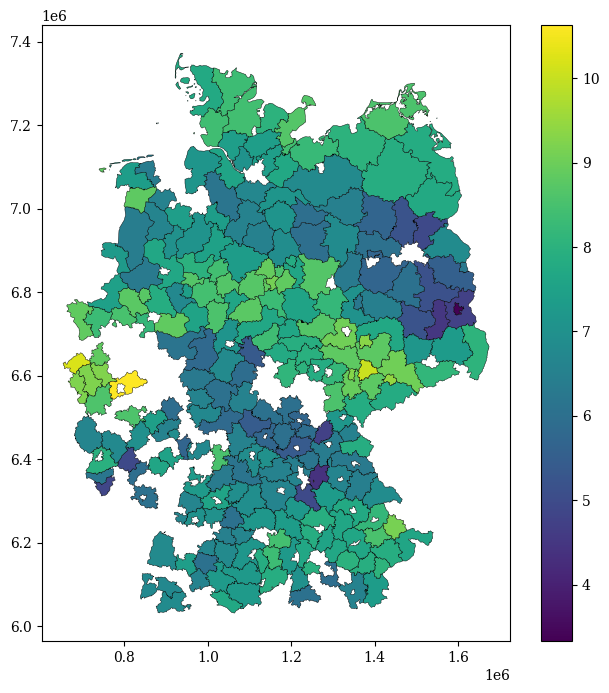

In [166]:
test_df.plot(column='value', edgecolor='k', linewidth=0.3, figsize=(8, 8), legend=True)